# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
data.shape

(13150, 10)

In [4]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [6]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [7]:
X_train.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
475678,2012,141137,1,0,0,0,0,0,0
23079,2015,13671,0,0,0,0,1,0,0
291651,2013,58614,0,0,0,0,0,1,0
277196,2011,47704,0,1,0,0,0,0,0
14923,2016,37504,0,0,0,0,1,0,0


In [8]:
j = 1
print(X.columns[j])

Mileage


In [9]:
# Split the variable in num_ctp points
import numpy as np
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

In [10]:
# Only unique values for filter binary and few unique values features
splits = np.unique(splits)
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

In [11]:
k=5

In [12]:
filter_l = X_train.iloc[:, j] < splits[k]

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [13]:
y_r.shape

(4397,)

### Gini

In [14]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [15]:
gini_l = gini(y_l)
gini_l

0.20546796183268556

In [16]:
gini_r = gini(y_r)
gini_r

0.39541215507151295

### Gini Impiruty

In [17]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [18]:
gini_impurity(X_train.iloc[:, j], y_train, splits[k])

0.18753536503271223

### Best split 

In [19]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [20]:
j, split, gain = best_split(X_train, y_train, 5)
j, split, gain

(1, 56598.66666666667, 0.23507164147905313)

In [21]:
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [22]:
y_train.shape[0], y_l.shape[0], y_r.shape[0]

(8810, 5873, 2937)

In [23]:
y_train.mean(), y_l.mean(), y_r.mean()

(0.5780930760499432, 0.8205346500936489, 0.09329247531494722)

### Árbol de decisión

In [24]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [25]:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)

### Predicción

In [26]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [27]:
y_pred = tree_predict(X_test, tree)

### Accuracy

In [28]:
from sklearn import metrics
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.f1_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

0.8730414746543779
0.8930304795185401
             precision    recall  f1-score   support

          0       0.87      0.82      0.84      1812
          1       0.88      0.91      0.89      2528

avg / total       0.87      0.87      0.87      4340



# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [29]:
feature_cols = X.columns
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [30]:
import math
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

max_features=round(math.log(feature_cols.itemsize))
#tree1 = DecisionTreeClassifier(max_features=max_features, max_depth=None, random_state=1)

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Index.itemsize is deprecated and will be removed in a future version
  """


In [31]:
bagclas = BaggingClassifier(DecisionTreeClassifier(max_features=2, max_depth=None, random_state=1), n_estimators=100, 
                          bootstrap=True, oob_score=True, random_state=1, n_jobs=-1)

In [32]:
bagclas.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=-1, oob_score=True,
         random_state=1, verbose=0, warm_start=False)

### Accuracy

In [33]:
y_pred = bagclas.predict(X_test)

In [34]:
y_pred

array([0, 1, 1, ..., 1, 1, 0])

In [35]:
from sklearn import metrics
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.f1_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

0.838479262672811
0.8613254203758656
             precision    recall  f1-score   support

          0       0.81      0.81      0.81      1812
          1       0.86      0.86      0.86      2528

avg / total       0.84      0.84      0.84      4340



# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
from sklearn.model_selection import cross_val_score
pd.Series(cross_val_score(clf, X_train, y_train, cv=10)).describe()

count    10.000000
mean      0.840521
std       0.007283
min       0.827469
25%       0.835604
50%       0.840998
75%       0.845958
max       0.850340
dtype: float64

In [38]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000240
5,M_CamryL,0.002356
7,M_CamrySE,0.006132
2,M_Camry,0.007026
6,M_CamryLE,0.007796
8,M_CamryXLE,0.009500
3,M_Camry4dr,0.048597
0,Year,0.218333
1,Mileage,0.700020


### Accuracy

In [40]:
y_pred = clf.predict(X_test)

In [41]:
from sklearn import metrics
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.f1_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

0.841705069124424
0.8632291459287279
             precision    recall  f1-score   support

          0       0.80      0.82      0.81      1812
          1       0.87      0.86      0.86      2528

avg / total       0.84      0.84      0.84      4340



# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [42]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf1 = RandomForestClassifier(n_estimators=100, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf1, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

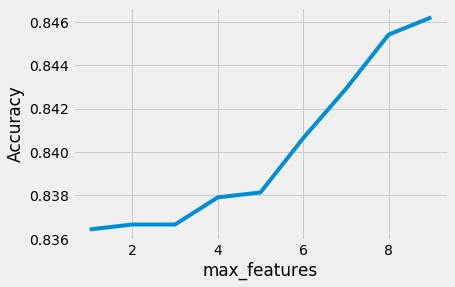

In [43]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [44]:
# max_features=9 is best and n_estimators=100 is sufficiently large
clf1 = RandomForestClassifier(n_estimators=100, max_features=9, random_state=1, n_jobs=-1)
clf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [45]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf1.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000060
3,M_Camry4dr,0.001319
5,M_CamryL,0.005743
7,M_CamrySE,0.006896
2,M_Camry,0.008718
8,M_CamryXLE,0.009801
6,M_CamryLE,0.015042
0,Year,0.123864
1,Mileage,0.828558


### Accuracy

In [46]:
y_pred = clf1.predict(X_test)

In [47]:
from sklearn import metrics
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.f1_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

0.847926267281106
0.8701298701298701
             precision    recall  f1-score   support

          0       0.82      0.81      0.82      1812
          1       0.87      0.87      0.87      2528

avg / total       0.85      0.85      0.85      4340

